In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pandas import read_stata
import math
import japanize_matplotlib
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
# https://amatosan.hatenablog.com/entry/2016/02/15/003513

# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XRSUJU

In [2]:
# 第４学年のデータ読み込み
df4 = read_stata('./dataverse_files/data/final4.dta')

In [3]:
# 第５学年のデータの読み込み
df5 = read_stata('./dataverse_files/data/final5.dta')
df5

,schlcode,c_size,c_boys,c_girls,c_numcl,c_pik,c_status,c_leom,c_tip,c_num5rd,...,nmath_n,verb_n,flverb_n,nverb_n,impute,nverb_m,nmath_m,tip_s,townid,tipuach
0,11005,54,24,30,9,1,2,1,5,2,...,55.0,72.744728,27.256363,55.0,0,NaN,NaN,24.0,26104.0,24
1,11005,54,24,30,9,1,2,1,5,2,...,55.0,72.744728,27.256363,55.0,0,NaN,NaN,24.0,26104.0,24
2,11006,37,21,16,12,2,2,1,7,2,...,15.0,75.470001,20.000000,15.0,0,NaN,NaN,38.0,26104.0,38
3,11006,37,21,16,12,2,2,1,7,2,...,15.0,75.470001,20.000000,15.0,1,20.0,20.0,38.0,26104.0,38
4,11009,32,17,15,6,1,2,1,1,1,...,32.0,73.970001,40.599998,32.0,0,NaN,NaN,6.0,4622.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,61351,19,8,11,6,2,1,1,,1,...,17.0,81.290001,5.900000,17.0,0,NaN,NaN,26.0,12682.0,26
2025,61363,27,14,13,7,1,1,1,,1,...,22.0,79.360001,18.200001,22.0,0,NaN,NaN,NaN,NaN,22
2026,61364,70,42,28,15,1,1,1,,2,...,40.0,79.292442,29.292683,41.0,0,NaN,NaN,NaN,NaN,0
2027,61364,70,42,28,15,1,1,1,,2,...,40.0,79.292442,29.292683,41.0,0,NaN,NaN,NaN,NaN,0


In [4]:
df5.columns

Index(['schlcode', 'c_size', 'c_boys', 'c_girls', 'c_numcl', 'c_pik',
       'c_status', 'c_leom', 'c_tip', 'c_num5rd', 'c_type', 'flgrm5',
       'mrkgrm5', 'ngrm5', 'flmth5', 'mrkmth5', 'nmth5', 'towncode',
       'townname', 'popcode', 'tip_a', 'grade', 'classid', 'classize',
       '_type_', '_freq_', 'cohsize', 'mathsize', 'avgmath', 'passmath',
       'verbsize', 'avgverb', 'passverb', 'studchk', 'misskov2', 'missagg',
       'nmiss_k', 'nmiss_a', 'classct', 'math_n', 'flmath_n', 'nmath_n',
       'verb_n', 'flverb_n', 'nverb_n', 'impute', 'nverb_m', 'nmath_m',
       'tip_s', 'townid', 'tipuach'],
      dtype='object')

# 前処理

In [5]:
# 100点overしているものを補正する
df5.avgmath = df5.avgmath.apply(lambda x : x - 100 if x > 100 else x)
df5.avgverb = df5.avgverb.apply(lambda x : x - 100 if x > 100 else x)

In [6]:
# クラスサイズ関数による予測計算
# func1は理論値通りになる
df5['func1'] = df5.c_size / (((df5.c_size - 1) / 40).apply(lambda x : math.floor(x)) + 1)
# func2はファジーな感じになる
df5['func2'] = df5.cohsize / ((df5.cohsize / 40).apply(lambda x : math.floor(x)) + 1)

In [7]:
# 0の値を欠損地へ変換する
df5.avgmath[df5.mathsize == 0] = np.nan
df5.passmath[df5.mathsize == 0] = np.nan
df5.passverb[df5.verbsize == 0] = np.nan
df5.passverb[df5.verbsize == 0] = np.nan

/var/folders/j0/dprt9y4n7hjcjnr0fw0wxf300000gn/T/ipykernel_36307/3565938284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.avgmath[df5.mathsize == 0] = np.nan
/var/folders/j0/dprt9y4n7hjcjnr0fw0wxf300000gn/T/ipykernel_36307/3565938284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.passmath[df5.mathsize == 0] = np.nan
/var/folders/j0/dprt9y4n7hjcjnr0fw0wxf300000gn/T/ipykernel_36307/3565938284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [8]:
# 一部の変な個体を落とす
df5 = df5[(1 < df5.classize) & (df5.classize < 45) & (df5.c_size > 5)] #5件脱落
df5 = df5[(df5.c_leom == 1) & (df5.c_pik < 3)] #脱落なし
df5 = df5[~df5.avgverb.isna()] #5件脱落

In [9]:
# cutoffを判定する関数、RDDの介入、非介入を表現する,discountinutity。介入が１、非介入が０とする
df5['disc'] = df5.c_size.apply(lambda x: 1 if 36 <= x <=45 or 76 <= x <=85 or 116 <= x <=125 or 156 <= x <= 165 else 0)

In [10]:
# 特徴量エンジニアリング
df5['c_size**2'] = df5.c_size ** 2

In [62]:
# 線形区分の作成,入学者数【c_size】の代わりに使うために作成。
def senkei(x):
    result = 0
    if 0 <= x <= 40:
        result = x
    elif 41 <= x <= 80:
        result = x/2 + 20
    elif 81 <= x <= 120:
        result = x/3 + 100/3
    elif 121 <= x <= 160:
        result = x/4 + 130/4
    else:
        result = x
    return result

df5['trend'] = df5.c_size.apply(senkei)

In [12]:
df5 = df5[~df5.avgmath.isna()]
df5 = df5[~df5.avgverb.isna()]

# 可視化

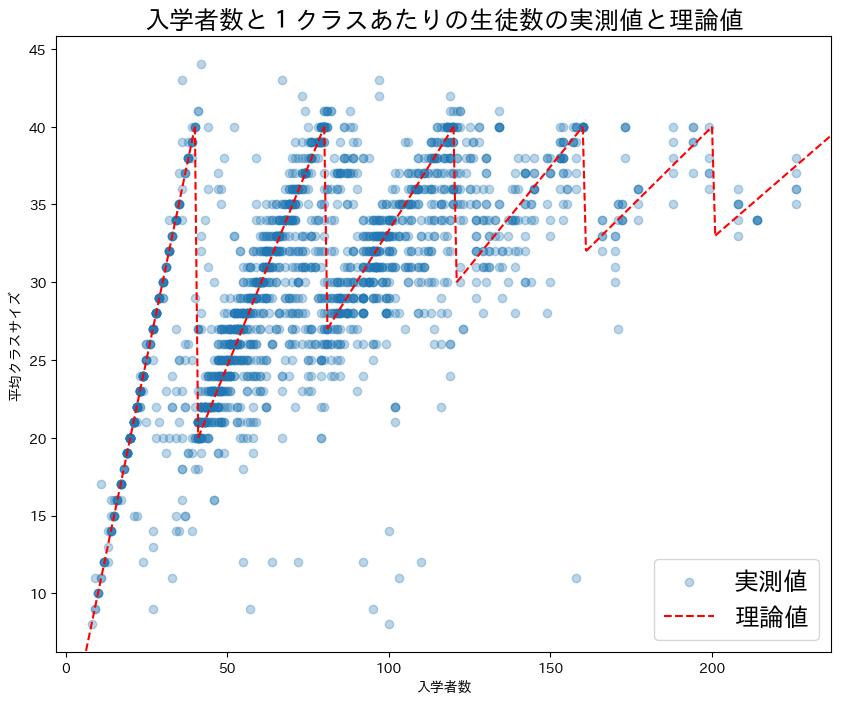

In [117]:
# クラスサイズと理論値の可視化
start_point = [[0,0],[40,40],[41,20],[80,40],[81,27],[120,40],[121,30],[160,40],[161,32],[200,40],[201,33]]
end_point = [[40,40],[41,20],[80,40],[81,27],[120,40],[121,30],[160,40],[161,32],[200,40],[201,33],[240,40]]
lines = [ [sp,ep] for sp,ep in zip(start_point, end_point)]
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(df5.c_size, df5.classize, alpha=0.3, label='実測値')
# ax.scatter(df5.c_size,df5.func1, alpha=0.3, c='g')
ax.set_title('入学者数と１クラスあたりの生徒数の実測値と理論値',fontsize=18)
ax.set_xlabel('入学者数')
ax.set_ylabel('平均クラスサイズ')
ax.add_collection(LineCollection(lines, colors='r', linestyles='--', label='理論値'))
ax.legend(fontsize=18)
plt.savefig('classsize_and_theory.png')
plt.show()

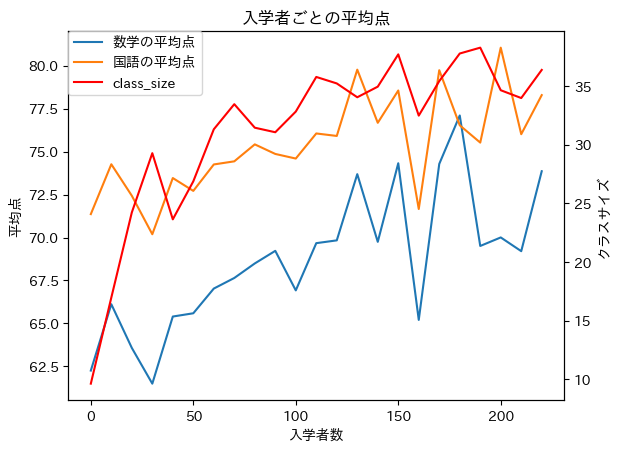

In [14]:
# ビニングする幅を設定する
df5['c_size_bins'] = pd.cut(df5.c_size, np.arange(0,300,10), labels=False)*10

# 成績とクラスサイズの可視化
fig,ax = plt.subplots()

# 2軸で表示するようにする
ax1 = ax.twinx()
ax.plot(df5.groupby(df5['c_size_bins'])[['avgmath','avgverb']].mean(), label=['数学の平均点','国語の平均点'])
ax1.plot(df5.groupby(df5['c_size_bins'])['classize'].mean(),c='r',label='class_size')

# ラベルをまとめて表示させる
handler1, label1 = ax.get_legend_handles_labels()
handler2, label2 = ax1.get_legend_handles_labels()
# ラベルの合体
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

# 軸名やタイトルの設定
ax.set_title('入学者ごとの平均点')
ax.set_xlabel('入学者数')
ax1.set_ylabel('クラスサイズ')
ax.set_ylabel('平均点')

plt.savefig('avg_point_and_class_size.png')
plt.show()

# 操作変数法

In [38]:
df5[['func2', 'func1', 'c_size']].corr()

,func2,func1,c_size
func2,1.000000,0.800394,0.642160
func1,0.800394,1.000000,0.642265
c_size,0.642160,0.642265,1.000000


In [55]:
df5.columns

Index(['schlcode', 'c_size', 'c_boys', 'c_girls', 'c_numcl', 'c_pik',
       'c_status', 'c_leom', 'c_tip', 'c_num5rd', 'c_type', 'flgrm5',
       'mrkgrm5', 'ngrm5', 'flmth5', 'mrkmth5', 'nmth5', 'towncode',
       'townname', 'popcode', 'tip_a', 'grade', 'classid', 'classize',
       '_type_', '_freq_', 'cohsize', 'mathsize', 'avgmath', 'passmath',
       'verbsize', 'avgverb', 'passverb', 'studchk', 'misskov2', 'missagg',
       'nmiss_k', 'nmiss_a', 'classct', 'math_n', 'flmath_n', 'nmath_n',
       'verb_n', 'flverb_n', 'nverb_n', 'impute', 'nverb_m', 'nmath_m',
       'tip_s', 'townid', 'tipuach', 'func1', 'func2', 'disc', 'c_size**2',
       'trend', 'c_size_bins'],
      dtype='object')

In [113]:
# t値を確認するために１段階目の回帰分析を単独で実施、操作変数のt値が3.2以上、F値が１０以上ならOK。この時、２段階目回帰で使う共変量を含める。
formula_1 = 'classize ~ func2 + tipuach + c_size'
res_1 = ols(formula_1, data=df5).fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:               classize   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     1036.
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:15:46   Log-Likelihood:                -5711.6
No. Observations:                2018   AIC:                         1.143e+04
Df Residuals:                    2014   BIC:                         1.145e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2593      0.544     15.189      0.0

In [115]:
# 変数の設定
# func2は結果変数である平均点とは関係がない一方で、クラスサイズとは強い相関がある。
# tipuachとはPD指数のこと。PD指数とは学校外の教育資源の多さをイスラエル政府が指数化したもの
# c_sizeは入学者数
# classizeが１クラスあたりの人数
# 被説明変数 ~ 定数項 + 外生的説明変数 + [内生的説明変数 ~ 操作変数]
formula = 'avgverb ~ 1 + c_size + tipuach + [classize ~  func2]'

# ２段階回帰、操作変数法
res = IV2SLS.from_formula(formula=formula, data=df5).fit(cov_type='unadjusted')
print(res.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                avgverb   R-squared:                      0.3516
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3506
No. Observations:                2018   F-statistic:                    1161.6
Date:                Mon, Apr 10 2023   P-value (F-stat)                0.0000
Time:                        11:17:28   Distribution:                  chi2(3)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      84.626     1.1708     72.283     0.0000      82.332      86.921
c_size         0.0162     0.0059     2.7579     0.00

In [91]:
res_1 = IV2SLS.from_formula(formula=formula, data=df5.query('disc == 1')).fit(cov_type='unadjusted')
print('カットオフポイント＋ー５のみデータを利用')
print(res_1.summary)

カットオフポイント＋ー５のみデータを利用
                          IV-2SLS Estimation Summary                          
Dep. Variable:                avgverb   R-squared:                      0.3354
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3313
No. Observations:                 491   F-statistic:                    302.52
Date:                Thu, Apr 06 2023   P-value (F-stat)                0.0000
Time:                        18:30:32   Distribution:                  chi2(3)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      89.796     3.3208     27.041     0.0000      83.287      96.304
c_size         0.0357     0.018

In [110]:
# LinearRegressionで２段階推定を実施
df = df5.query('disc == 1')
x = df[['func2','c_size','tipuach']]
y = df['classize']
first_model = LinearRegression()
first_model.fit(x,y)
df['classize_predict'] = first_model.predict(x)

x = df[['classize_predict','c_size','tipuach']]
y = df['avgverb']
second_model = LinearRegression()
second_model.fit(x,y)

/var/folders/j0/dprt9y4n7hjcjnr0fw0wxf300000gn/T/ipykernel_36307/2931293343.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['classize_predict'] = first_model.predict(x)


LinearRegression()

In [111]:
second_model.feature_names_in_, second_model.coef_, second_model.intercept_

(array(['classize_predict', 'c_size', 'tipuach'], dtype=object),
 array([-0.38850528,  0.03567346, -0.4404774 ]),
 89.7958974302245)

In [112]:
len(df)

491

# 参考文献

データセット  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XRSUJU  

サイト  
dtaファイルの読み込み  
https://amatosan.hatenablog.com/entry/2016/02/15/003513  

はてなブログ、少人数教室の効果推定  
https://ill-identified.hatenablog.com/entry/2014/12/18/012338  

操作変数の良し悪しを判断する方法について記述がある。  
https://www.nishiyama.kier.kyoto-u.ac.jp/2018/jugyochukei3.pdf  

pythonで２段階回帰分析  
https://py4etrics.github.io/19_IV2SLS.html

矢内先生のスライド  
http://yukiyanai.github.io/jp/classes/econometrics2/contents/slides/metrics2_topic09_slides.pdf  

日本、回帰不連続デザイン  
https://core.ac.uk/reader/229320690  

